In [176]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb
from tqdm import tqdm
import warnings
import networkx as nx
import pdb
import pickle
from scipy.sparse.linalg import svds, eigs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

In [2]:
train_csv = pd.read_csv('train.csv')

In [3]:
train_csv.head(5)

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


# Checking for NA values

In [4]:
train_csv[train_csv.isna().any(1)]

,source_node,destination_node


# Checking for duplicate values

In [5]:
sum(train_csv.duplicated())

0

### Gathering info

In [6]:
g = nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph())

In [7]:
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


# Exploratory data Analysis

### Number of users

In [8]:
print("Total number of users: ",len(g.nodes()))

Total number of users:  1862220


### Number of followers for each person

In [9]:
followers = list(dict(g.in_degree()).values())

In [10]:
followers.sort()

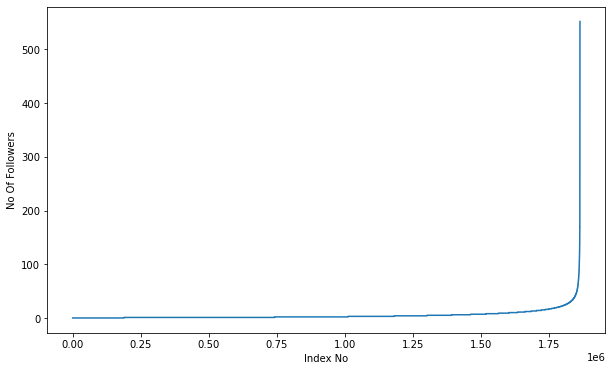

In [11]:
plt.figure(figsize=(10,6))
plt.plot(followers)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

###  Analysing till 1.5M index

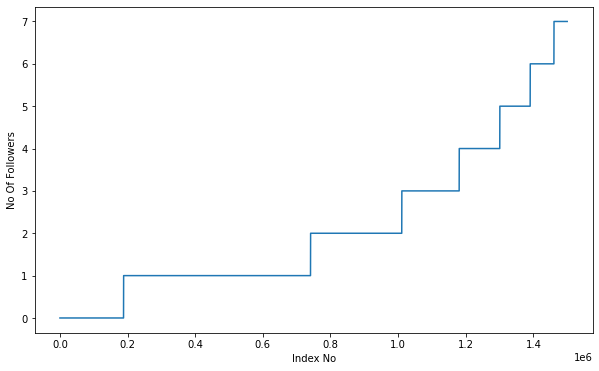

In [12]:
plt.figure(figsize=(10,6))
plt.plot(followers[:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

In [13]:
for i in range(1,11):
    print(90+i,'percentile value is: ',np.percentile(followers,(90+i)))

91 percentile value is:  13.0
92 percentile value is:  14.0
93 percentile value is:  15.0
94 percentile value is:  17.0
95 percentile value is:  19.0
96 percentile value is:  21.0
97 percentile value is:  24.0
98 percentile value is:  29.0
99 percentile value is:  40.0
100 percentile value is:  552.0


#### 99% of users have only 40 followers

In [14]:
for i in range(1,11):
    print(99+i/10,'percentile value is: ',np.percentile(followers,(99+i/10)))

99.1 percentile value is:  42.0
99.2 percentile value is:  44.0
99.3 percentile value is:  47.0
99.4 percentile value is:  50.0
99.5 percentile value is:  55.0
99.6 percentile value is:  61.0
99.7 percentile value is:  70.0
99.8 percentile value is:  84.0
99.9 percentile value is:  112.0
100.0 percentile value is:  552.0


#### 99.9% of users have only 112 followers

Text(0.5, 0, 'PDF of followers')

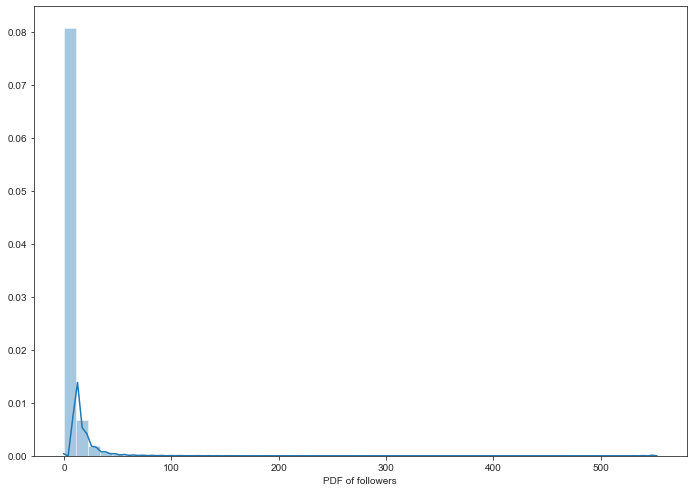

In [15]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(followers)
plt.xlabel('PDF of followers')

### Number of following for each person

In [16]:
following = list(dict(g.out_degree()).values())

In [17]:
following.sort()

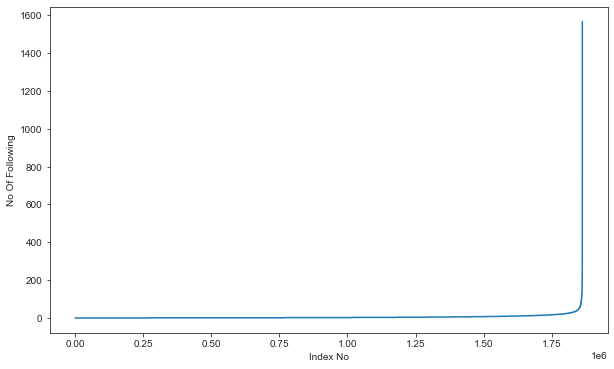

In [18]:
plt.figure(figsize=(10,6))
plt.plot(following)
plt.xlabel('Index No')
plt.ylabel('No Of Following')
plt.show()

###  Analysing till 1.5M index

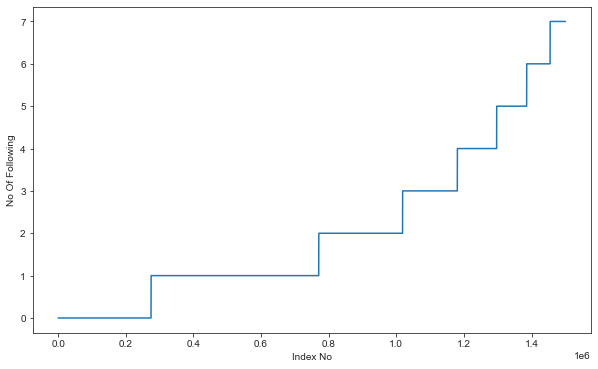

In [19]:
plt.figure(figsize=(10,6))
plt.plot(following[:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Following')
plt.show()

In [20]:
for i in range(1,11):
    print(90+i,'percentile value is: ',np.percentile(following,(90+i)))

91 percentile value is:  13.0
92 percentile value is:  14.0
93 percentile value is:  15.0
94 percentile value is:  17.0
95 percentile value is:  19.0
96 percentile value is:  21.0
97 percentile value is:  24.0
98 percentile value is:  29.0
99 percentile value is:  40.0
100 percentile value is:  1566.0


In [21]:
for i in range(1,11):
    print(99+i/10,'percentile value is: ',np.percentile(following,(99+i/10)))

99.1 percentile value is:  42.0
99.2 percentile value is:  45.0
99.3 percentile value is:  48.0
99.4 percentile value is:  52.0
99.5 percentile value is:  56.0
99.6 percentile value is:  63.0
99.7 percentile value is:  73.0
99.8 percentile value is:  90.0
99.9 percentile value is:  123.0
100.0 percentile value is:  1566.0


#### 99.9 % users have uptill 123 following

Text(0.5, 0, 'PDF of following')

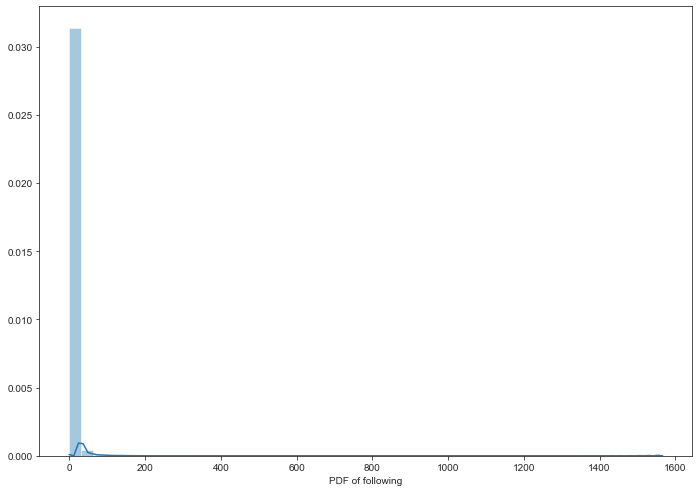

In [22]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(following)
plt.xlabel('PDF of following')

In [23]:
print('Number of people who are not following anyone: ',sum(np.array(following)==0),' and % is ',(sum(np.array(following)==0)/len(following)*100))

Number of people who are not following anyone:  274512  and % is  14.741115442858524


In [24]:
print('No of persons having zero followers are' ,sum(np.array(followers)==0),'and % is',
                                sum(np.array(followers)==0)*100/len(followers) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [25]:
count = 0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0:
        if len(list(g.successors(i)))==0:
            count+=1

In [26]:
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


### Follower + Followees for each node

In [27]:
from collections import Counter
dict_in = dict(g.in_degree)
dict_out = dict(g.out_degree)
d = Counter(dict_in)+ Counter(dict_out)

In [28]:
follower_followees  = list(d.values())

In [29]:
follower_followees.sort()

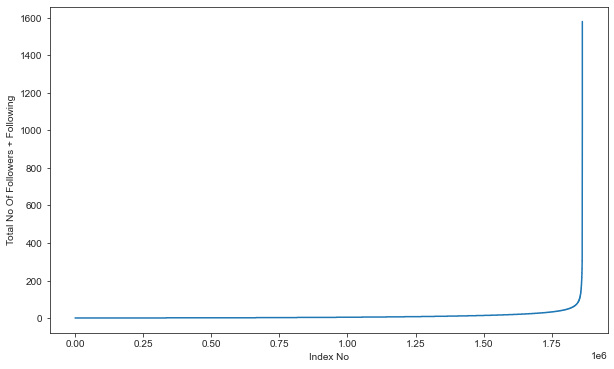

In [30]:
plt.figure(figsize=(10,6))
plt.plot(follower_followees)
plt.xlabel('Index No')
plt.ylabel('Total No Of Followers + Following')
plt.show()

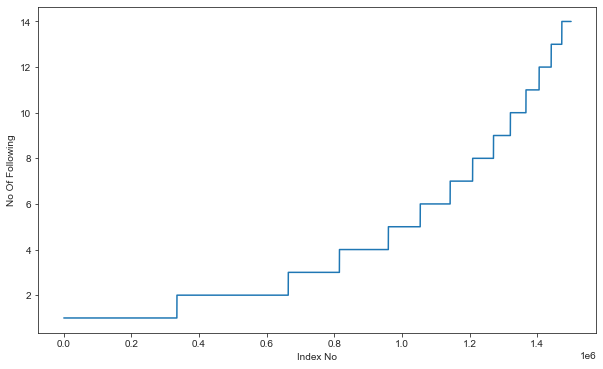

In [31]:
plt.figure(figsize=(10,6))
plt.plot(follower_followees[:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Following')
plt.show()

In [32]:
for i in range(1,11):
    print(90+i,'percentile value is: ',np.percentile(follower_followees,(90+i)))

91 percentile value is:  26.0
92 percentile value is:  28.0
93 percentile value is:  31.0
94 percentile value is:  33.0
95 percentile value is:  37.0
96 percentile value is:  41.0
97 percentile value is:  48.0
98 percentile value is:  58.0
99 percentile value is:  79.0
100 percentile value is:  1579.0


In [33]:
for i in range(1,11):
    print(99+i/10,'percentile value is: ',np.percentile(follower_followees,(99+i/10)))

99.1 percentile value is:  83.0
99.2 percentile value is:  87.0
99.3 percentile value is:  93.0
99.4 percentile value is:  99.0
99.5 percentile value is:  108.0
99.6 percentile value is:  120.0
99.7 percentile value is:  138.0
99.8 percentile value is:  168.0
99.9 percentile value is:  221.0
100.0 percentile value is:  1579.0


Text(0.5, 0, 'PDF of following+followers')

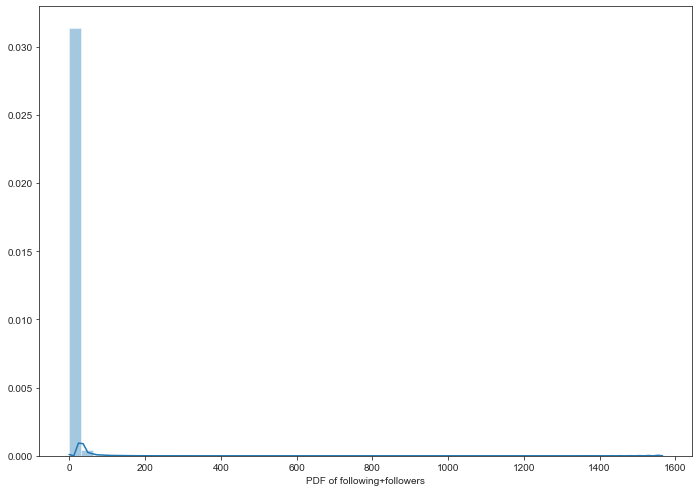

In [34]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(following)
plt.xlabel('PDF of following+followers')

In [35]:
print('Min number of followers + following: ',min(follower_followees))

Min number of followers + following:  1


In [36]:
print('users with just one follower + followee in %: ',np.sum(np.array(follower_followees)==1)/len(follower_followees)*100)

users with just one follower + followee in %:  17.951208772325504


In [37]:
print('Max number of follower + following: ',max(follower_followees))

Max number of follower + following:  1579


In [38]:
print('user with max follower+following: ',np.sum(np.array(follower_followees)==1579))

user with max follower+following:  1


##  Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

In [39]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile('missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('missing_edges_final.p','rb'))

Wall time: 1.89 s


In [40]:
len(missing_edges)

9437519

# Train and Test split

In [41]:
from sklearn.model_selection import train_test_split
if (os.path.isfile('train_pos_after_eda.csv')) and (os.path.isfile('test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


In [42]:
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
test_graph=nx.read_edgelist('test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))
print(nx.info(test_graph))

# finding the unique nodes in the both train and test graphs
train_nodes_pos = set(train_graph.nodes())
test_nodes_pos = set(test_graph.nodes())

trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
trY_teN = len(train_nodes_pos - test_nodes_pos)
teY_trN = len(test_nodes_pos - train_nodes_pos)

print('no of people common in train and test -- ',trY_teY)
print('no of people present in train but not present in test -- ',trY_teN)

print('no of people present in test but not present in train -- ',teY_trN)
print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


In [43]:
X_train_pos = pd.read_csv('train_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_test_pos = pd.read_csv('test_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_train_neg = pd.read_csv('train_neg_after_eda.csv', names=['source_node', 'destination_node'])
X_test_neg = pd.read_csv('test_neg_after_eda.csv', names=['source_node', 'destination_node'])

print('='*60)
print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

X_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg)) 

Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 7550015
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 1887504


In [44]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)


# Feature Creation

In [45]:
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


## Jaccard Index
The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members for two sets to see which members are shared and which are distinct. It’s a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations. 

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

via: http://www.statisticshowto.com/jaccard-index/

In [46]:
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) ==0 | len(set(train_graph.predecessors(b))) ==0:
            return 0
        else:
            sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                    (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    
    except:
        
        return 0


In [47]:
jaccard_for_followers(2,470294)

0.045454545454545456

In [48]:
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) ==0 | len(set(train_graph.successors(b))) ==0:
            return 0
        else:
            sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
        return sim
    except:
        return 0 

In [49]:
jaccard_for_followees(2,470294)

0.034482758620689655

In [50]:
jaccard_for_followees(2,3)

0.0

## Cosine Distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [51]:
def cosine_distance_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) ==0 | len(set(train_graph.predecessors(b))) ==0:
            return 0
        else:
            sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
            return sim
    except:
        return 0

In [52]:
print(cosine_distance_followers(2,470294))

0.02886751345948129


In [53]:
def cosine_distance_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) ==0 | len(set(train_graph.successors(b))) ==0:
            return 0
        else:
            sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                     (math.sqrt(len(set(train_graph.successors(a))))*(len(set(train_graph.successors(b)))))
            return sim
    except:
        return 0

In [54]:
print(cosine_distance_followees(2,470294))

0.01788854381999832


## Page Rank

PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites.

<img src='PageRanks-Example.svg.png'/>

Source: Wikipedia

In [55]:
pr = pickle.load(open('page_rank.p','rb'))

In [56]:
min_pr = min( pr.values())
print(min_pr)

1.6556497245737814e-07


In [57]:
mean_pr = sum(pr.values())/len(pr)
print(mean_pr)

5.615699699389075e-07


In [58]:
max_pr = max(pr.values())
print(max_pr)

2.7098251341935827e-05


## Shortest path

In [59]:
def compute_shortest_path(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p = nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
            return p 
        else:
            p = nx.shortest_path_length(train_graph,source=a,target=b)
            return p
    except:
        return -1

In [60]:
compute_shortest_path(77697, 826021)

10

In [61]:
compute_shortest_path(669354,1635354)

-1

## Checking for same community

In [62]:
wcc = list(nx.weakly_connected_components(train_graph))

In [63]:

def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [64]:
belongs_to_same_wcc(861, 1659750)

0

## Adam-Adar index
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

The definition is based on the concept that common elements with very large neighbourhoods are less significant when predicting a connection between two nodes compared with elements shared between a small number of nodes.

Source: Wikipedia

In [65]:
def adam_adar(a,b):
    
    try:
        n = list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if n!=0:
            sum =0
            for i in n:
                sum+= 1/np.log10(len(train_graph.predecessors(i)))
            return sum
        
        else:
            return 0
    except:
        return 0

In [66]:
adam_adar(1,189226)

0

In [67]:
adam_adar(669354,5636582)

0

## Users following each other back

In [68]:
def follow_back(a,b):
    try:
        if train_graph.has_edge(a,b):
            if train_graph.has_edge(b,a):
                return 1
            else:
                return 0
        else:
            return 0
    except:
        return 0 

In [69]:
follow_back(1847924,928426)

0

In [70]:
follow_back(669354,1635354)

0

## Katz Centrality

In [71]:
if not os.path.isfile('katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('katz.p','wb'))
else:
    katz = pickle.load(open('katz.p','rb'))

In [72]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [73]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


## Hits Score

In [74]:
if not os.path.isfile('hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('hits.p','wb'))
else:
    hits = pickle.load(open('hits.p','rb'))

In [75]:
print('min',hits[1][min(hits[1], key=hits[1].get)])
print('max',hits[1][max(hits[1], key=hits[1].get)])
print('mean',float(sum(hits[1].values())) / len(hits[1]))

min 0.0
max 0.0054775458498681736
mean 5.615699699335403e-07


# Preferential Attachment
One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. It may be noted that the similarity index does not require any node neighbor information; therefore, this similarity index has the lowest computational complexity.

Source: http://be.amazd.com/link-prediction/

In [76]:
def preferential_attachment_followers(a,b):
    try:
        a_followers = len(set(train_graph.predecessors(a)))
        b_followers = len(set(train_graph.predecessors(b)))
        return a_followers*b_followers
    
    except:
        return 0

In [77]:
preferential_attachment_followers(273084,470294)

220

In [78]:
def preferential_attachment_followees(a,b):
    try:
        a_followees = len(set(train_graph.successors(a)))
        b_followees = len(set(train_graph.successors(b)))
        return a_followees*b_followees
    except:
        return 0 

In [79]:
preferential_attachment_followees(273084, 470294)

375

## Total_Followers,Total_followees,Common_Followers, Common Followees,

In [80]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

## Weight features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. credit - Graph-based Features for Supervised Link Prediction William Cukierski, Benjamin Hamner, Bo Yang
\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}
it is directed graph so calculated Weighted in and Weighted out differently

In [81]:
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|█████████████████████████████████████████████████████████████████████| 1780722/1780722 [00:19<00:00, 92341.26it/s]


## SVD dot feature

In [82]:
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [83]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [84]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [85]:
def svd_u(a,b):
    try:
        
        s_id = sadj_dict[a]
        d_id = sadj_dict[b]
        s_u = U[s_id]
        d_u = U[d_id]
        return math.log(np.dot(s_u,d_u))
        
    except:
        return 0 

In [86]:
svd_u(273084, 1505602)

-25.219625777963095

In [87]:
def svd_v(a,b):
    try:
        s_id = sadj_dict[a]
        d_id = sadj_dict[b]
        s_v = V.T[s_id]
        d_v = V.T[d_id]
        return math.log(np.dot(s_v,d_v))
        
    except:
        return 0

In [88]:
svd_v(273084, 1505602)

-26.825091396784412

In [89]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

## Beacuse of deficiency in computational power I will reduce training data to 100,000 samples and test data to 20,000 samples

In [90]:
colnames = ['source_node','destination_node']
X_train = pd.read_csv('train_after_eda.csv',header=None,names=colnames)

In [91]:
X_train.head(5)

,source_node,destination_node
0,273084,1505602
1,912810,1678443
2,365429,1523458
3,527014,1605979
4,1228116,471233


In [92]:
X_train.shape

(15100030, 2)

In [93]:
y_train = pd.read_csv('train_y.csv',header=None)

In [94]:
y_train

,0
0,1
1,1
2,1
3,1
4,1
...,...
15100025,0
15100026,0
15100027,0
15100028,0


In [95]:
X_test = pd.read_csv('test_after_eda.csv',header=None,names=colnames)

In [96]:
X_test.head(5)

,source_node,destination_node
0,848424,784690
1,1248963,444518
2,264224,132395
3,549680,326829
4,875380,1394902


In [97]:
X_test.shape

(3775008, 2)

In [98]:
y_test = pd.read_csv('test_y.csv',header=None)

In [99]:
y_test.shape

(3775008, 1)

#### Adding the y_data to train and test samples

In [100]:
X_train['link_present'] = y_train
X_test['link_present']=y_test

In [101]:
X_train.head(1)

,source_node,destination_node,link_present
0,273084,1505602,1


In [102]:
X_test.head(1)

,source_node,destination_node,link_present
0,848424,784690,1


### Sampling train and test data

#### Sampling train data

In [103]:
import random
random_train_sample_row = set()
while len(random_train_sample_row)<100000:
    random_row = np.random.randint(0,X_train.shape[0])
    random_train_sample_row.add(random_row)

In [104]:
X_train_sample = X_train.iloc[list(random_train_sample_row)]

In [105]:
X_train_sample.shape

(100000, 3)

In [106]:
X_train_sample.link_present.value_counts()  # Making sure that class is evenly distributed 

0    50177
1    49823
Name: link_present, dtype: int64

In [107]:
X_train_sample.head(3)

,source_node,destination_node,link_present
6291458,1010723,1185956,1
6553612,1051841,1355238,1
3670031,1271092,1288365,1


#### Sampling test data

In [108]:
random_test_sample_row = set()
while len(random_test_sample_row)<20000:
    random_row = np.random.randint(0,X_test.shape[0])
    random_test_sample_row.add(random_row)

In [109]:
X_test_sample = X_test.iloc[list(random_test_sample_row)]

In [110]:
X_test_sample.link_present.value_counts() # Making sure that class is evenly distributed 

1    10099
0     9901
Name: link_present, dtype: int64

In [111]:
X_test_sample.shape

(20000, 3)

In [112]:
X_test_sample.head(3)

,source_node,destination_node,link_present
917505,808619,1098894,1
1179649,601375,1369764,1
1441796,1226940,1653856,1


# Feature Addition

In [113]:
    #mapping jaccard followers

X_train_sample['jaccard_followers'] = X_train_sample.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
X_test_sample['jaccard_followers'] = X_test_sample.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccard followees
X_train_sample['jaccard_followees'] = X_train_sample.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
X_test_sample['jaccard_followees'] = X_test_sample.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccard followers 
X_train_sample['cosine_followers'] = X_train_sample.apply(lambda row:
                                            cosine_distance_followers(row['source_node'],row['destination_node']),axis=1)
X_test_sample['cosine_followers'] = X_test_sample.apply(lambda row:
                                            cosine_distance_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccard followees 
X_train_sample['cosine_followees'] = X_train_sample.apply(lambda row:
                                            cosine_distance_followees(row['source_node'],row['destination_node']),axis=1)
X_test_sample['cosine_followees'] = X_test_sample.apply(lambda row:
                                            cosine_distance_followees(row['source_node'],row['destination_node']),axis=1)

    #mapping adam/adar feature
X_train_sample['adam_adar'] = X_train_sample.apply(lambda row: adam_adar(row['source_node'],row['destination_node']),axis =1)  
X_test_sample['adam_adar'] = X_test_sample.apply(lambda row: adam_adar(row['source_node'],row['destination_node']),axis =1)

    #mapping follow back
X_train_sample['follow_back'] = X_train_sample.apply(lambda row: follow_back(row['source_node'],row['destination_node']),axis =1)  
X_test_sample['follow_back'] = X_test_sample.apply(lambda row: follow_back(row['source_node'],row['destination_node']),axis =1)

   #mapping preferential attachment followees
X_train_sample['pref_attach_followees'] = X_train_sample.apply(lambda row: preferential_attachment_followees(row['source_node'],row['destination_node']),axis =1)  
X_test_sample['pref_attach_followees'] = X_test_sample.apply(lambda row: preferential_attachment_followees(row['source_node'],row['destination_node']),axis =1)

  #mapping preferential attachment followers
X_train_sample['pref_attach_followers'] = X_train_sample.apply(lambda row: preferential_attachment_followers(row['source_node'],row['destination_node']),axis =1)  
X_test_sample['pref_attach_followers'] = X_test_sample.apply(lambda row: preferential_attachment_followers(row['source_node'],row['destination_node']),axis =1)
  
  #mapping svd_U feature
X_train_sample['svd_dot_U'] = X_train_sample.apply(lambda row: svd_u(row['source_node'],row['destination_node']),axis=1)
X_test_sample['svd_dot_U'] = X_test_sample.apply(lambda row: svd_u(row['source_node'],row['destination_node']),axis=1)

   #mapping svd_V feature
X_train_sample['svd_dot_V'] = X_train_sample.apply(lambda row: svd_v(row['source_node'],row['destination_node']),axis=1)
X_test_sample['svd_dot_V'] = X_test_sample.apply(lambda row: svd_v(row['source_node'],row['destination_node']),axis=1)

  #mapping shortest path feature
X_train_sample['shortest_path'] = X_train_sample.apply(lambda row: compute_shortest_path(row['source_node'],row['destination_node']),axis=1)
X_test_sample['shortest_path'] = X_test_sample.apply(lambda row: compute_shortest_path(row['source_node'],row['destination_node']),axis=1)

  #mapping same_community feature
X_train_sample['same_community'] = X_train_sample.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
X_test_sample['same_community'] = X_test_sample.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
                                           

In [114]:
# Mapping total followers,followees, common followers,followees
X_train_sample['num_followers_s'], X_train_sample['num_followers_d'], \
    X_train_sample['num_followees_s'], X_train_sample['num_followees_d'], \
    X_train_sample['inter_followers'], X_train_sample['inter_followees']= compute_features_stage1(X_train_sample)
    
X_test_sample['num_followers_s'], X_test_sample['num_followers_d'], \
    X_test_sample['num_followees_s'], X_test_sample['num_followees_d'], \
    X_test_sample['inter_followers'], X_test_sample['inter_followees']= compute_features_stage1(X_test_sample)

In [115]:
#mapping weight-in feature
X_train_sample['weight_in'] = X_train_sample.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
X_test_sample['weight_in'] = X_test_sample.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))

#mapping weight-out feature
X_train_sample['weight_out'] = X_train_sample.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))
X_test_sample['weight_out'] = X_test_sample.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

#some feature engg features done on weight
X_train_sample['weight_f1'] = X_train_sample.weight_in + X_train_sample.weight_out
X_train_sample['weight_f2'] = X_train_sample.weight_in * X_train_sample.weight_out
X_train_sample['weight_f3'] = (2*X_train_sample.weight_in + 1*X_train_sample.weight_out)
X_train_sample['weight_f4'] = (1*X_train_sample.weight_in + 2*X_train_sample.weight_out)

X_test_sample['weight_f1'] = X_test_sample.weight_in + X_test_sample.weight_out
X_test_sample['weight_f2'] = X_test_sample.weight_in * X_test_sample.weight_out
X_test_sample['weight_f3'] = (2*X_test_sample.weight_in + 1*X_test_sample.weight_out)
X_test_sample['weight_f4'] = (1*X_test_sample.weight_in + 2*X_test_sample.weight_out)

#mapping page rank feature
X_train_sample['page_rank_s'] = X_train_sample.source_node.apply(lambda x:pr.get(x,mean_pr))
X_train_sample['page_rank_d'] = X_train_sample.destination_node.apply(lambda x:pr.get(x,mean_pr))

X_test_sample['page_rank_s'] = X_test_sample.source_node.apply(lambda x:pr.get(x,mean_pr))
X_test_sample['page_rank_d'] = X_test_sample.destination_node.apply(lambda x:pr.get(x,mean_pr))

#mapping katz feature
X_train_sample['katz_s'] = X_train_sample.source_node.apply(lambda x: katz.get(x,mean_katz))
X_train_sample['katz_d'] = X_train_sample.destination_node.apply(lambda x: katz.get(x,mean_katz))

X_test_sample['katz_s'] = X_test_sample.source_node.apply(lambda x: katz.get(x,mean_katz))
X_test_sample['katz_d'] = X_test_sample.destination_node.apply(lambda x: katz.get(x,mean_katz))

#mapping hubs score
X_train_sample['hubs_s'] = X_train_sample.source_node.apply(lambda x: hits[0].get(x,0))
X_train_sample['hubs_d'] = X_train_sample.destination_node.apply(lambda x: hits[0].get(x,0))

X_test_sample['hubs_s'] = X_test_sample.source_node.apply(lambda x: hits[0].get(x,0))
X_test_sample['hubs_d'] = X_test_sample.destination_node.apply(lambda x: hits[0].get(x,0))

#mapping authorities score
X_train_sample['authorities_s'] = X_train_sample.source_node.apply(lambda x: hits[1].get(x,0))
X_train_sample['authorities_d'] = X_train_sample.destination_node.apply(lambda x: hits[1].get(x,0))

X_test_sample['authorities_s'] = X_test_sample.source_node.apply(lambda x: hits[1].get(x,0))
X_test_sample['authorities_d'] = X_test_sample.destination_node.apply(lambda x: hits[1].get(x,0))

In [116]:
X_train_sample[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
X_train_sample.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
X_train_sample[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
X_train_sample.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
X_train_sample[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
X_train_sample.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

X_train_sample[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
X_train_sample.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    
X_test_sample[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
X_test_sample.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
X_test_sample[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
X_test_sample.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

   
    
X_test_sample[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
X_test_sample.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

X_test_sample[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
X_test_sample.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

In [117]:
X_train_sample.head(3)

,source_node,destination_node,link_present,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,adam_adar,follow_back,pref_attach_followees,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
6291458,1010723,1185956,1,0.000000,0.00,0.000000,0.000000,0,1,160,...,2.731791e-13,5.551673e-15,7.243611e-13,2.523976e-17,-5.810401e-16,2.408229e-13,2.557135e-14,1.001455e-15,1.367988e-13,6.455486e-18
6553612,1051841,1355238,1,0.266667,0.55,0.164957,0.177512,0,1,240,...,5.056419e-15,2.293394e-15,2.678512e-13,2.995811e-09,-3.101308e-17,8.660957e-19,1.530805e-15,1.123991e-15,1.719397e-15,9.029851e-10
3670031,1271092,1288365,1,0.200000,0.25,0.176777,0.235702,0,1,6,...,1.137743e-08,1.884176e-15,1.856644e-15,1.106696e-16,-4.023262e-15,3.296041e-15,1.162572e-08,1.913851e-15,1.880693e-15,1.146107e-16


In [118]:
X_train_sample.columns

Index(['source_node', 'destination_node', 'link_present', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'adam_adar', 'follow_back', 'pref_attach_followees',
       'pref_attach_followers', 'svd_dot_U', 'svd_dot_V', 'shortest_path',
       'same_community', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object'

In [119]:
X_test_sample.head(3)


,source_node,destination_node,link_present,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,adam_adar,follow_back,pref_attach_followees,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
917505,808619,1098894,1,0.0,0.000000,0.0,0.00000,0,0,46,...,1.588659e-07,6.515794e-11,1.148506e-10,4.037878e-12,-3.796623e-15,9.552882e-08,2.131200e-12,4.657093e-13,2.079463e-09,2.270670e-16
1179649,601375,1369764,1,0.0,0.000000,0.0,0.00000,0,0,171,...,6.364747e-11,3.039484e-13,2.700122e-14,1.896726e-15,-9.150557e-16,2.805086e-15,2.694283e-14,8.609006e-17,1.650542e-16,3.220262e-18
1441796,1226940,1653856,1,0.0,0.009804,0.0,0.01037,0,0,930,...,6.230235e-05,9.405142e-11,1.277081e-09,2.243196e-11,-1.325034e-11,2.694142e-11,2.611384e-09,6.132215e-10,5.008377e-11,3.527300e-13


# Feeding into Machine learning models

In [120]:
y_train_sample = X_train_sample['link_present']
y_test_sample = X_test_sample['link_present']

In [121]:
X_train_sample.drop(['source_node', 'destination_node','link_present'],axis=1,inplace=True)
X_test_sample.drop(['source_node', 'destination_node','link_present'],axis=1,inplace=True)

In [122]:
X_train_sample.head(2)

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,adam_adar,follow_back,pref_attach_followees,pref_attach_followers,svd_dot_U,svd_dot_V,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
6291458,0.000000,0.00,0.000000,0.000000,0,1,160,50,-51.750676,-54.366186,...,2.731791e-13,5.551673e-15,7.243611e-13,2.523976e-17,-5.810401e-16,2.408229e-13,2.557135e-14,1.001455e-15,1.367988e-13,6.455486e-18
6553612,0.266667,0.55,0.164957,0.177512,0,1,240,84,-44.508145,-40.451366,...,5.056419e-15,2.293394e-15,2.678512e-13,2.995811e-09,-3.101308e-17,8.660957e-19,1.530805e-15,1.123991e-15,1.719397e-15,9.029851e-10


## Using Random Forest

### Using Estimator as hyperparameter

Estimators =  10 Train Score 0.9157243122139755 test Score 0.8228610385183501
Estimators =  50 Train Score 0.9250551449449594 test Score 0.8414552736982642
Estimators =  100 Train Score 0.9232954545454546 test Score 0.8380422691879866
Estimators =  250 Train Score 0.9236762402088772 test Score 0.8396666666666667
Estimators =  450 Train Score 0.9236264884061 test Score 0.8404042647712127


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

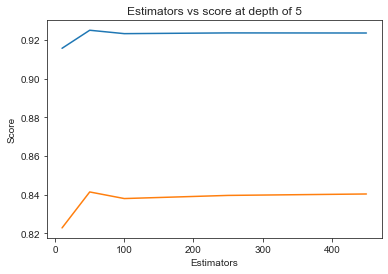

In [123]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(X_train_sample,y_train_sample)
    train_sc = f1_score(y_train_sample,clf.predict(X_train_sample))
    test_sc = f1_score(y_test_sample,clf.predict(X_test_sample))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

In [124]:
X_train_sample.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'adam_adar', 'follow_back', 'pref_attach_followees',
       'pref_attach_followers', 'svd_dot_U', 'svd_dot_V', 'shortest_path',
       'same_community', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [125]:
X_train_sample.follow_back.value_counts()

0    72350
1    27650
Name: follow_back, dtype: int64

### Using Depth as hyperparameter

depth =  3 Train Score 0.8996850163749764 test Score 0.833451530194752
depth =  9 Train Score 0.9544569073348781 test Score 0.8486501530754245
depth =  11 Train Score 0.9616806585370835 test Score 0.8466867806458822
depth =  15 Train Score 0.9679323434526413 test Score 0.8463304036276101
depth =  20 Train Score 0.9677805992889792 test Score 0.848907225691347
depth =  35 Train Score 0.9674095301972502 test Score 0.8485186631702282
depth =  50 Train Score 0.9674095301972502 test Score 0.8485186631702282
depth =  70 Train Score 0.9674095301972502 test Score 0.8485186631702282
depth =  130 Train Score 0.9674095301972502 test Score 0.8485186631702282


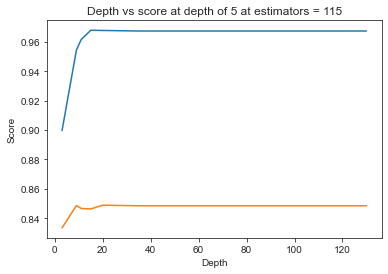

In [129]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(X_train_sample,y_train_sample)
    train_sc = f1_score(y_train_sample,clf.predict(X_train_sample))
    test_sc = f1_score(y_test_sample,clf.predict(X_test_sample))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

### Using Randomized search CV

In [137]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(95,125),
              "max_depth": sp_randint(10,20),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(X_train_sample,y_train_sample)
print('mean train scores',rf_random.cv_results_['mean_test_score'])

mean train scores [0.96583979 0.96593856 0.96612523 0.96684313 0.96452541]


In [145]:
rf_random.best_params_

{'max_depth': 14,
 'min_samples_leaf': 30,
 'min_samples_split': 111,
 'n_estimators': 102}

In [151]:
best_params_dist = {'n_estimators':[102],
                   'min_samples_leaf':[30],
                   'max_depth':[14],
                   'min_samples_split':[111]}

In [155]:
clf_best = RandomForestClassifier(random_state=25,n_jobs=-1,n_estimators=102,min_samples_leaf=30,max_depth=14,min_samples_split=111)

clf_best.fit(X_train_sample,y_train_sample)
print('Train f1 score: ',f1_score(y_train_sample,clf_best.predict(X_train_sample)))
print('Train Accuracy is: ',accuracy_score(y_train_sample,clf_best.predict(X_train_sample)))
print('Test f1 score: ',f1_score(y_test_sample,clf_best.predict(X_test_sample)))
print('Test Accuracy is: ',accuracy_score(y_test_sample,clf_best.predict(X_test_sample)))


Train f1 score:  0.969165234895235
Train Accuracy is:  0.96967
Test f1 score:  0.8488911234009273
Test Accuracy is:  0.86475


## Confusion Matrix

In [162]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

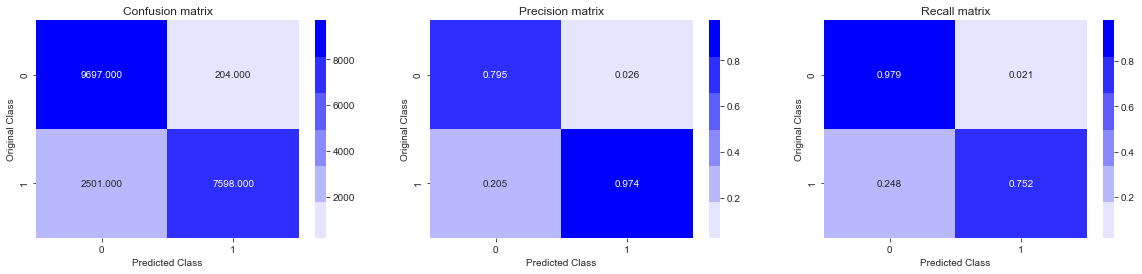

In [163]:
plot_confusion_matrix(y_test_sample,clf_best.predict(X_test_sample))

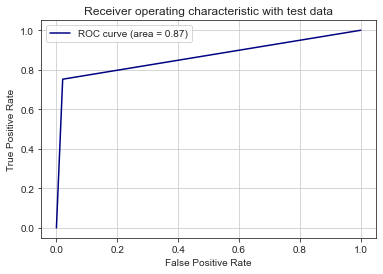

In [166]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test_sample,clf_best.predict(X_test_sample))
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.grid()
plt.show()

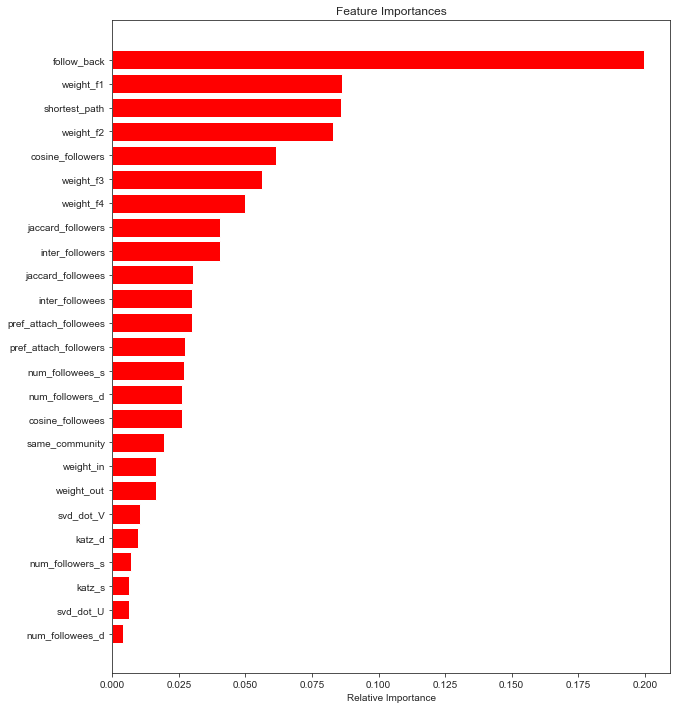

In [167]:
features = X_train_sample.columns
importances = clf_best.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Using XGBoost

In [172]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'f1'

params = {      
        'learning_rate':[0.01,0.05,0.1,0.2],  
        'n_estimators' :[200,500,1000,2000],   # number of decision trees         
        'subsample': [0.6,0.8,1.0],              # row sampling
        'colsample_bytree': [0.6,0.8,1.0],       # Column sampling
        'max_depth': [3,5,6,7],      # Depth of decision tree                          
          }
xgboost = XGBClassifier()          
random_cfl=RandomizedSearchCV(xgboost,param_distributions = params,verbose=30,n_jobs=-1)
random_cfl.fit(X_train_sample,y_train_sample)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 36.7min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 36

[03:19:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=N

In [173]:
random_cfl.best_params_

{'subsample': 0.6,
 'n_estimators': 1000,
 'max_depth': 6,
 'learning_rate': 0.1,
 'colsample_bytree': 1.0}

In [174]:
best_xgb = XGBClassifier(subsample= 0.6,n_estimators= 1000,max_depth= 6,learning_rate= 0.1,colsample_bytree= 1.0)

best_xgb.fit(X_train_sample,y_train_sample)

calb_clf = (best_xgb)

calb_clf.fit(X_train_sample,y_train_sample)

[10:05:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:07:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [177]:
predict_y_train = calb_clf.predict_proba(X_train_sample)
print("The log loss for Train data is: ",log_loss(y_train_sample,predict_y_train))

The log loss for Train data is:  0.0019136619474531187


In [178]:
predict_y_test = calb_clf.predict_proba(X_test_sample)
print("The log loss for Test data is: ",log_loss(y_test_sample,predict_y_test))

The log loss for Test data is:  1.6388172724467593


In [179]:

y_train_pred = calb_clf.predict(X_train_sample)
y_test_pred = calb_clf.predict(X_test_sample)

In [183]:

print('Train f1 score',f1_score(y_train_sample,y_train_pred))
print('Test f1 score',f1_score(y_test_sample,y_test_pred))

Train f1 score 1.0
Test f1 score 0.8182554372975474


Train confusion_matrix


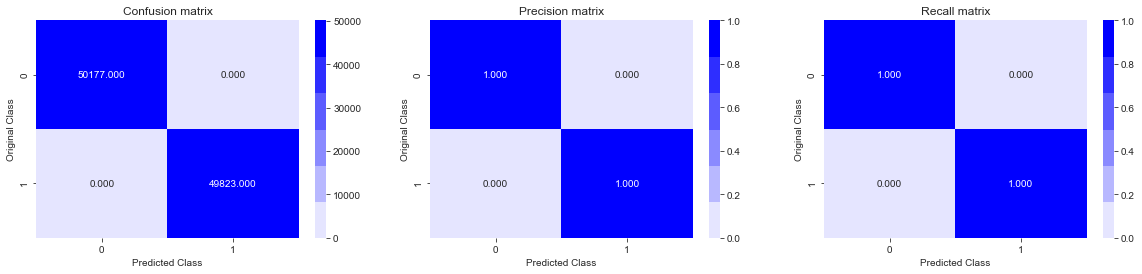

Test confusion_matrix


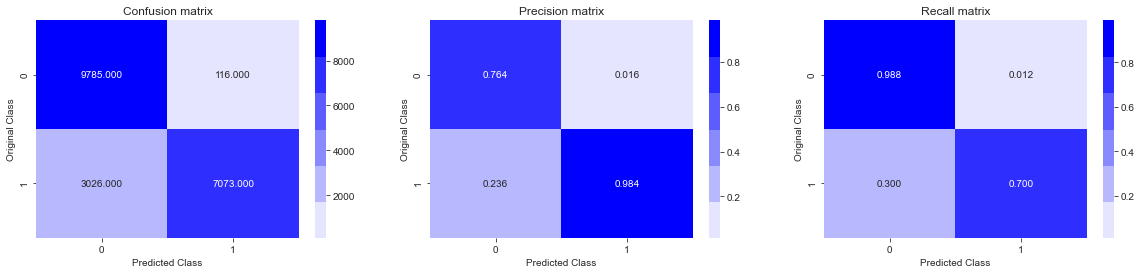

In [184]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train_sample,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test_sample,y_test_pred)

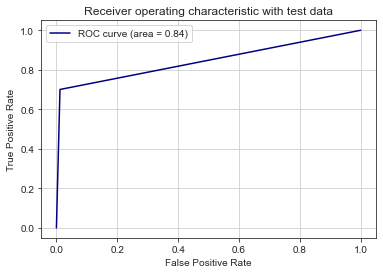

In [187]:
fpr,tpr,ths = roc_curve(y_test_sample,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.grid()
plt.show()

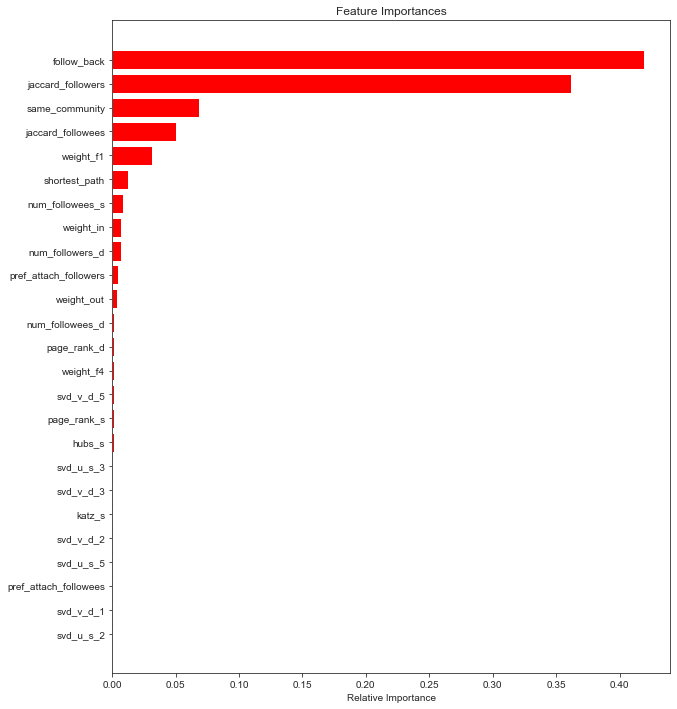

In [189]:
features = X_train_sample.columns
importances = calb_clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()